In [145]:
import sys
sys.path.append('../../')
from search import search_local
import numpy as np
from tools.tools import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Seeing how mismatched exponential density is, try spherical density. Define parammeters. All units in kpc.

In [146]:
d_pixel = 0.001
d_max = 6
d_min = 0
bins = int((d_max - d_min)/d_pixel)
epsilon = 0.1
bins_close = int((epsilon - d_min)/d_pixel)

Get gaia catalogue, convert from cartesian to cylindrical

In [147]:
samples = search_local.get_entire_catalogue()
x, y, z, vx, vy, vz = samples.T
cylcoord = rect_to_cyl(x, y, z, vx, vy, vz)
R = cylcoord[:, 0]
z = cylcoord[:, 3]

Get stars close to the sun: epsilon kpc around sun

In [148]:
sun_galactic = np.array([0, 0, 0, 0, 0, 0])
close_stars = search_local.search_phase_space(*sun_galactic, epsilon = epsilon, v_scale = 0)
x_close, y_close, z_close, vx_close, vy_close, vz_close = close_stars.T
cyl_close = rect_to_cyl(x_close, y_close, z_close, vx_close, vy_close, vz_close)
R_close = cyl_close[:, 0]
z_close = cyl_close[:, 3]

Change the data of both gaia rv and close stars to just storing distance.

In [149]:
dist_coord = np.sqrt((R-8.300)**2 + (z - 0.027)**2)
dist_close = np.sqrt((R_close-8.300)**2 + (z_close-0.027)**2)

Graph 1D histogram for distribution of distance for all of gaia catalogue

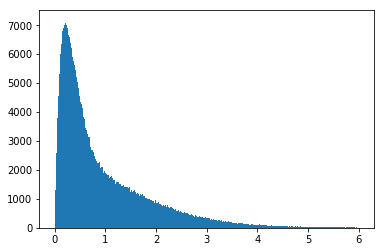

In [150]:
histogram_gaia, edges, patches = plt.hist(dist_coord, bins = bins_d, range = (d_min, d_max))

Graph 1D histogram for distribution of distance for all stars in epsilon region

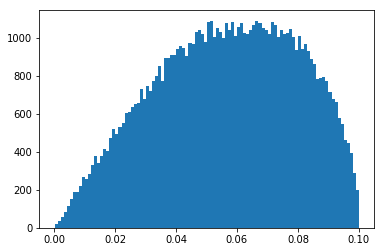

In [151]:
histogram_close, edges_close, patches_close = plt.hist(dist_close, bins = bins_close)

Define a function that get the gaia spherical number density function from histogram result

In [152]:
def n_gaia(d, histogram):
    d_index = ((d-d_min)/d_pixel).astype(int)-1
    result = []
    for i in range(np.size(d)):
        result.append(histogram[d_index[i]])
    return np.array(result)

Define the true sperhical number density function

In [153]:
def n(d, n_0):
    return n_0*4*(np.pi)*(d**2)

Curve fit spherical density with stars in epsilon region.

In [154]:
popt, pcov = curve_fit(n_spherical, dist_close, n_gaia(dist_close, histogram_close))
n_0 = popt[0]
std_n_0 = pcov[0][0]
print("optimized n_0 =", n_0)
print("standard deviation of n_0 =", std_n_0)

optimized n_0 = 13271.139874408214
standard deviation of n_0 = 1035.2240753821131


Plot theoretical prediction over histogram in epsilon neighborhood.

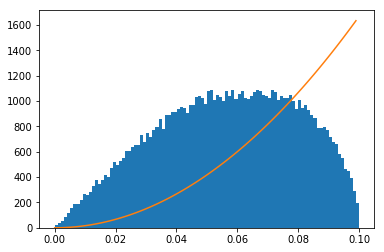

In [155]:
plt.hist(dist_close, bins = bins_close)
d_linspace = np.linspace(d_min, epsilon, bins_close, endpoint = False)
plt.plot(d_linspace, n(d_linspace, n_0))

Plot theoretical prediction over real histogram for all stars.

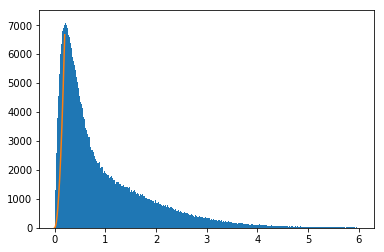

In [156]:
plt.hist(dist_coord, bins = bins_d, range = (d_min, d_max))
d_linspace = np.linspace(d_min, 0.2, bins, endpoint = False)
plt.plot(d_linspace, n(d_linspace, n_0))

Calculate the 